In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasmdata/Sarcasm_Headlines_Dataset.json


In [2]:
# Importing required libraries
import json
import tensorflow as tf
import requests
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt

In [3]:
# I get the dataset

data = requests.get('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json')
# print 550 characters
print(data.text[0:550])

[
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0},
{"article_link": "https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-s


In [4]:
# Separate the json into sentences and labels
tweets = []
labels = []
for item in data.json():
    tweets.append(item['headline'])
    labels.append(item['is_sarcastic'])
print(pd.DataFrame({'tweets' : tweets[0:10], 'label':labels[0:10]}))




                                              tweets  label
0  former versace store clerk sues over secret 'b...      0
1  the 'roseanne' revival catches up to our thorn...      0
2  mom starting to fear son's web series closest ...      1
3  boehner just wants wife to listen, not come up...      1
4  j.k. rowling wishes snape happy birthday in th...      0
5                        advancing the world's women      0
6     the fascinating case for eating lab-grown meat      0
7  this ceo will send your kids to school, if you...      0
8  top snake handler leaves sinking huckabee camp...      1
9  friday's morning email: inside trump's presser...      0


To get both of tokenization and sequencing. 
Tokenization is a task of dividing a string into pieces, called as tokens, while throwing away certain characters like punctuation marks. Tokenization assigns a number to each unique word. Sequencing builds on top of tokenization, by representing sentences as a sequence of numbers.

In [5]:
# Splitting the dataset into Train and Test
trainSize = round(len(tweets) * .75)
trainTweet = tweets[0:trainSize]
testTweet = tweets[trainSize:]
trainLabels = labels[0:trainSize]
testLabels = labels[trainSize:]
# Setting tokenizer properties
vocab_length = 10000
oov_tokenizer = "<oov>"
# Fit the tokenizer on Training data
token = Tokenizer(num_words=vocab_length, oov_token=oov_tokenizer)
token.fit_on_texts(trainTweet)
word_index = token.word_index
# Setting the padding properties
maximum_length = 100
trunc_type='post'
padding_type='post'
# Creating padded sequences from train and test data
training_sequences = token.texts_to_sequences(trainTweet)
training_padded = pad_sequences(training_sequences, maxlen=maximum_length, padding=padding_type, truncating=trunc_type)
testing_sequences = token.texts_to_sequences(testTweet)
testing_padded = pad_sequences(testing_sequences, maxlen=maximum_length, padding=padding_type, truncating=trunc_type)

In [6]:
# Setting the model parameters

# top layer of embedding
embedding = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding, input_length=maximum_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
# the final layer is a sigmoid layer which returns the probability of the sentence being sarcastic.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


2022-08-22 21:56:22.482907: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The neural network was able to achieve 99% accuracy on the training dataset and 81% accuracy on the test dataset.

In [7]:
# Converting the lists to numpy arrays for Tensorflow 
training_padded = np.array(training_padded)
training_labels = np.array(trainLabels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testLabels)
# Training the model
num_epochs = 40
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

2022-08-22 21:56:22.656792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
626/626 - 2s - loss: 0.6615 - accuracy: 0.5985 - val_loss: 0.5654 - val_accuracy: 0.7992
Epoch 2/40
626/626 - 1s - loss: 0.4203 - accuracy: 0.8326 - val_loss: 0.3798 - val_accuracy: 0.8438
Epoch 3/40
626/626 - 1s - loss: 0.3033 - accuracy: 0.8793 - val_loss: 0.3496 - val_accuracy: 0.8543
Epoch 4/40
626/626 - 1s - loss: 0.2530 - accuracy: 0.9011 - val_loss: 0.3480 - val_accuracy: 0.8531
Epoch 5/40
626/626 - 1s - loss: 0.2192 - accuracy: 0.9164 - val_loss: 0.3510 - val_accuracy: 0.8498
Epoch 6/40
626/626 - 1s - loss: 0.1923 - accuracy: 0.9260 - val_loss: 0.3518 - val_accuracy: 0.8556
Epoch 7/40
626/626 - 1s - loss: 0.1710 - accuracy: 0.9355 - val_loss: 0.3645 - val_accuracy: 0.8549
Epoch 8/40
626/626 - 1s - loss: 0.1517 - accuracy: 0.9456 - val_loss: 0.4197 - val_accuracy: 0.8360
Epoch 9/40
626/626 - 1s - loss: 0.1375 - accuracy: 0.9513 - val_loss: 0.4007 - val_accuracy: 0.8531
Epoch 10/40
626/626 - 1s - loss: 0.1253 - accuracy: 0.9560 - val_loss: 0.4204 - val_accuracy: 0.8508

Using the model to predict more new tweets. The model for sentence 1 is  predicted a very high (almost 1)

In [8]:
tweets = ["crushes are great until you realize they'll never be interested in you", 
            "Sad that when someone drinks they treat you like shit and won't talk to you.",
          "that is the face of a tired man hahahahah", "You're never too old for Footie Pajamas.",
         "You are not allowed to open that until Christmas day!", "Hello I am here", "Auntie just called and said shes on her way"]
sequences = token.texts_to_sequences(tweets)
padded = pad_sequences(sequences, maxlen=maximum_length, padding=padding_type, truncating=trunc_type)
print("model predict", model.predict(padded))

model predict [[9.9993175e-01]
 [9.9999654e-01]
 [1.6014726e-09]
 [9.6053338e-01]
 [9.9823284e-01]
 [5.4744933e-06]
 [1.5920043e-05]]


Very hight accuracy around 99%

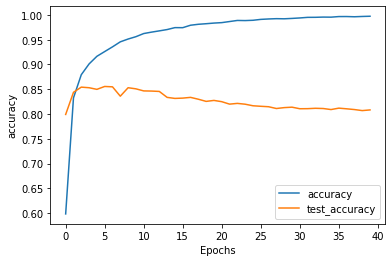

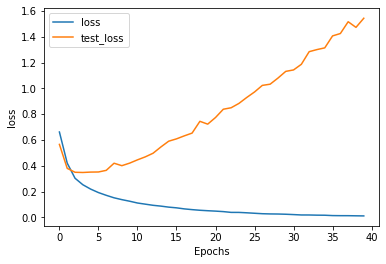

In [9]:
def sarcasmPlotGraphs(history, str):
    plt.plot(history.history[str])
    plt.plot(history.history['val_'+str])
    plt.xlabel("Epochs")
    plt.ylabel(str)
    plt.legend([str, 'test_'+str])
    plt.show()

sarcasmPlotGraphs(history, "accuracy")
sarcasmPlotGraphs(history, "loss")

plt.show()